In [1]:
# MovieLense
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from pycleora import SparseMatrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


2024-11-28 14:49:05.245376: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 14:49:05.245835: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 14:49:05.248611: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 14:49:05.255939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732801745.268545   38624 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732801745.27

## Downloading the data

In [3]:
data_dir = "../data"

In [4]:
def get_data(ds_name="movielens/100k-ratings"):
    def genre_id_to_text(genre_ids):
        return [genres[id] for id in genre_ids]

    ds = tfds.load(
        name=ds_name,
        split="all",
        data_dir=data_dir,
    )
    df = tfds.as_dataframe(ds)

    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].apply(
                lambda x: x.decode("utf-8") if isinstance(x, bytes) else x
            )

    genres = [
        "Action",
        "Adventure",
        "Animation",
        "Children",
        "Comedy",
        "Crime",
        "Documentary",
        "Drama",
        "Fantasy",
        "Film-Noir",
        "Horror",
        "IMAX",
        "Musical",
        "Mystery",
        "Romance",
        "Sci-Fi",
        "Thriller",
        "War",
        "Western",
        "unknown",
    ]
    df["genres_id"] = df["movie_genres"]
    df["movie_genres"] = df["movie_genres"].apply(genre_id_to_text)

    return df


In [5]:
data = get_data("movielens/1m-ratings")
data.head()


2024-11-28 14:49:07.164029: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-11-28 14:49:07.297817: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-11-28 14:51:26.559796: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,bucketized_user_age,movie_genres,movie_id,movie_title,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code,genres_id
0,35.0,"[Action, Drama]",3107,Backdraft (1991),977432193,True,130,18,technician/engineer,5.0,50021,"[0, 7]"
1,25.0,[Drama],2114,"Outsiders, The (1983)",965932967,False,3829,0,academic/educator,4.0,22307,[7]
2,18.0,"[Comedy, Sci-Fi]",256,Junior (1994),1012103552,False,1265,21,writer,1.0,49321,"[4, 15]"
3,18.0,"[Action, Horror]",1389,Jaws 3-D (1983),972004605,True,2896,14,sales/marketing,5.0,60073,"[0, 10]"
4,18.0,[Action],3635,"Spy Who Loved Me, The (1977)",961180111,True,5264,17,college/grad student,4.0,15217,[0]


## Prepare the data for proper embeddings

In [6]:
df = pd.DataFrame(data, columns=["movie_id", "user_id", "user_rating"])
negative_ratings = df[df["user_rating"] < 4].index

# Drop columns where rating < 4 -> we don't want to create a connection if user doesn't like the movie
df.drop(negative_ratings, inplace=True)



### Train-Test split - used for evaluation of our methods - maybe not needed??

In [7]:
# train, test = train_test_split(df, test_size=config["train_test_split"])
# train.shape, test.shape


In [8]:
# We do this after test-train spit to avoid data leakege

# Multiply the occurences if the score is 5 -> create a stronger connection  
df  = df.loc[df.index.repeat((df.user_rating-3)**2)]

In [9]:
df[df['movie_id']=='425']

,movie_id,user_id,user_rating
16881,425,2863,4.0
19348,425,5589,4.0
27350,425,5526,4.0
32760,425,4169,4.0
46680,425,687,4.0
...,...,...,...
952024,425,1043,5.0
952024,425,1043,5.0
952024,425,1043,5.0
952024,425,1043,5.0


In [10]:

# Drop columns we won't be using
df.drop(columns=["user_rating"], inplace=True)


In [11]:
df.head()

,movie_id,user_id
0,3107,130
0,3107,130
0,3107,130
0,3107,130
1,2114,3829


In [12]:
clique = df.groupby('user_id')['movie_id'].apply(list).values


## Hyperparameters - both for cleora and additional models

In [59]:
config = {
    # embedding computation
    "cleora_n_iter": 2,
    "cleora_dim": 1024,
    # dataset preparation
    "train_test_split": 0.2,
    "batch_size": 256,
    "test_batch_size": 1000,
    "epochs": [10],
    "alpha": [1e-4],
}

In [60]:
cleora_input = map(lambda x: ' '.join(x), clique)


In [61]:

# Create Markov transition matrix for the hypergraph

# Only one column - complex::reflexive
mat = SparseMatrix.from_iterator(cleora_input, columns='complex::reflexive::movie')


# Look at entity ids in the matrix, corresponding to embedding vectors
print(mat.entity_ids)

# Initialize embedding vectors externally, using text, image, random vectors
# embeddings = ...

# Or use built-in random deterministic initialization
embeddings = mat.initialize_deterministically(config["cleora_dim"])



['1097', '1270', '2018', '260', '150', '2028', '1545', '1836', '1962', '919', '1961', '2804', '2918', '1287', '2692', '3114', '1193', '783', '2791', '1207', '588', '1', '2797', '1246', '1566', '2762', '531', '2398', '3186', '594', '938', '1028', '527', '2355', '1035', '48', '3408', '1029', '608', '3105', '595', '1022', '2294', '1721', '1907', '32', '590', '1959', '3189', '1080', '648', '1409', '3039', '248', '7', '3347', '1573', '2140', '3072', '1204', '1380', '317', '292', '2657', '2967', '3481', '2874', '3296', '3928', '3593', '1257', '3447', '3591', '2135', '318', '2617', '3034', '2043', '3699', '2009', '1079', '2424', '2321', '2968', '1031', '3812', '1948', '435', '1286', '1019', '2375', '2108', '1084', '780', '802', '971', '3500', '1210', '2640', '2529', '1271', '2011', '1947', '1042', '2049', '2399', '1129', '1293', '914', '1408', '1009', '2109', '3671', '1127', '750', '2407', '2115', '1196', '3095', '2431', '2136', '1371', '2003', '2405', '1339', '3259', '2000', '1135', '3675', 

In [62]:
# Perform Markov random walk, then normalize however many times we want

# The optimal number depends on the graph, typically between 3 and 7 yields good results
# lower values tend to capture co-occurrence, higher iterations capture substitutability in a context

for i in range(config['cleora_n_iter']):
    # Can propagate with a symmetric matrix as well, but left Markov is a great default
    embeddings = mat.left_markov_propagate(embeddings)
    # Normalize with L2 norm by default, for the embeddings to reside on a hypersphere. Can use standardization instead.
    embeddings /= np.linalg.norm(embeddings, ord=2, axis=-1, keepdims=True)

# We're done, here are our embeddings





In [63]:
id_to_title = data.groupby("movie_id")['movie_title'].first().to_dict()


In [64]:
len(id_to_title)

3706

In [65]:
# for entity, embedding in zip(mat.entity_ids, embeddings):
#     print(id_to_title[entity], embedding)
#     break

In [66]:
embeddings_df = pd.DataFrame(embeddings, index=np.asanyarray(map(lambda x: id_to_title[x], mat.entity_ids)))

### Very advanced search engine

In [67]:
data[data['movie_title'].str.contains('kane', case=False, na=False)]['movie_title'].unique()

array(['Citizen Kane (1941)'], dtype=object)

In [71]:
example_movies = [
    # "Star Wars: Episode I - The Phantom Menace (1999)",
    # "Star Wars: Episode IV - A New Hope (1977)",
    # "Star Wars: Episode V - The Empire Strikes Back (1980)",
    # "Star Wars: Episode VI - Return of the Jedi (1983)",
    "Casablanca (1942)",
    "Citizen Kane (1941)",
    "Bambi (1942)",
    "Lion King, The (1994)",
    "Wizard of Oz, The (1939)",
    "Godfather, The (1972)",
    "Godfather: Part II, The (1974)",
    "Godfather: Part III, The (1990)",
    "Pulp Fiction (1994)",
    "Schindler's List (1993)",
    # "Three Colors: Blue (1993)",
    # "Three Colors: Red (1994)",
    # "Three Colors: White (1994)",
]


In [72]:
arrays = [embeddings_df.loc[[title]].to_numpy()[0] for title in example_movies]


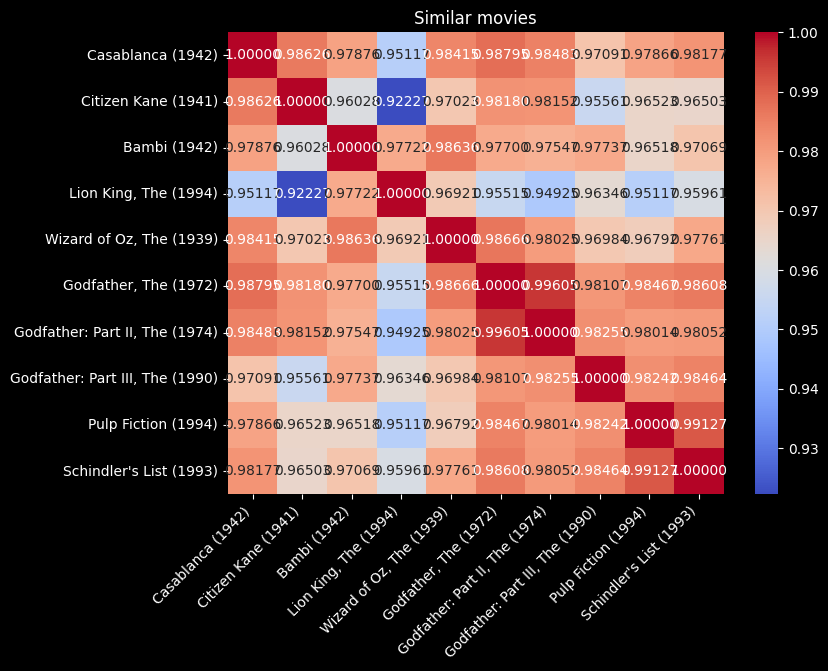

In [73]:
# We can now compare our embeddings with dot product (since they are L2 normalized)

n = len(arrays)
dot_products = np.zeros((n, n))  

for i in range(n):
    for j in range(n):
        dot_products[i, j] = np.dot(arrays[i], arrays[j])

plt.figure(figsize=(8, 6))
sns.heatmap(
    dot_products,
    annot=True,
    fmt=".5f",
    cmap="coolwarm",
    xticklabels=example_movies,
    yticklabels=example_movies,
)
plt.xticks(rotation=45, ha='right')
plt.title("Similar movies")
plt.show()